In [1]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [77]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")

In [78]:
# import sqlite3

# with sqlite3.connect("../laliga.sqlite") as conn:
#     df = pd.read_sql("SELECT * FROM Matches", con = conn)

# df = df.loc[-df.score.isnull()]

# def parse_score(score_as_string):
#         if score_as_string is None: 
#             return None
#         home_goals, away_goals = score_as_string.split(":")
#         home_goals = int(home_goals)
#         away_goals = int(away_goals)
#         if home_goals > away_goals: 
#             return -1
#         if away_goals > home_goals: 
#             return 1 
#         else: 
#             return 0  

# df['result'] = df['score'].apply(parse_score)
# df1 = df.copy()
# df aaaaa


In [79]:
df = pd.read_csv (r'Training_ML.csv')
df.dropna(subset = ["result"], inplace=True)
df1 = df.copy()


In [80]:
# convert strings in numbers 
le = preprocessing.LabelEncoder()


le.fit(pd.concat([df1.team, df1.Away_team]).drop_duplicates())

df1['team'] = le.transform(df1['team'])
df1['Away_team'] = le.transform(df1['Away_team'])

le.fit(df1['result'].drop_duplicates())
df1['result'] = le.transform(df1['result'])

df1[['team','Away_team','result']] = df1[['team','Away_team','result']].stack().rank(method='dense').unstack().astype(int)
df1  

,season,division,matchday,team,Away_team,W,L,T,result,GD,GD_cum,rank,last_results
0,1928-1929,1,1,8,13,0,1,0,1,-1,-1,7,['L']
1,1928-1929,1,2,8,57,0,2,0,1,-3,-4,10,"['L', 'L']"
2,1928-1929,1,3,8,117,0,2,1,2,0,-4,9,"['T', 'L', 'L']"
3,1928-1929,1,4,8,24,0,2,2,2,0,-4,9,"['T', 'T', 'L', 'L']"
4,1928-1929,1,5,8,12,1,2,2,3,1,-3,6,"['W', 'T', 'T', 'L', 'L']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95994,2021-2022,2,2,139,91,0,0,2,2,0,0,12,"['T', 'T']"
95995,2021-2022,2,3,139,35,1,0,2,3,1,1,6,"['W', 'T', 'T']"
95996,2021-2022,2,1,140,118,0,0,1,2,0,0,10,['T']
95997,2021-2022,2,2,140,76,0,0,2,2,0,0,14,"['T', 'T']"


The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [87]:
cor_matrix = df1.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

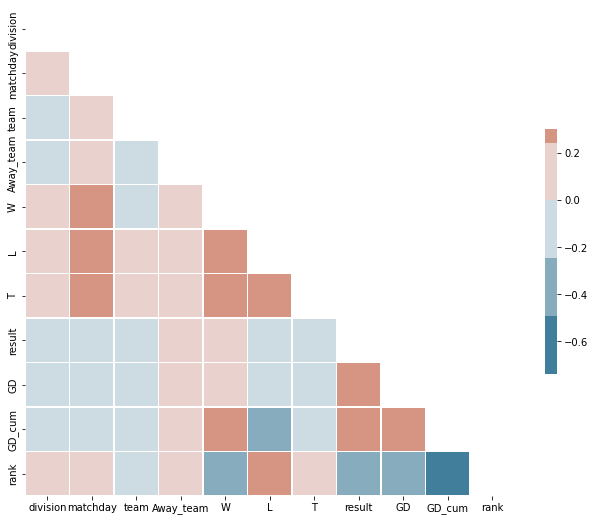

In [88]:
# Compute the correlation matrix
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

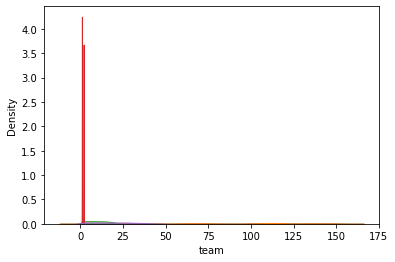

In [ ]:
feature_cols = ['team','Away_team','rank','division','matchday'] 
features = df1.loc[:,feature_cols]
target = df1.result


for col in features:
    sns.kdeplot(features[col], shade=True)

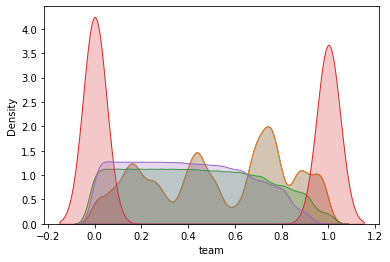

In [ ]:
#normalize with Normalize
# fit scaler on training data
scale_2 = MinMaxScaler().fit(features)

# transform training data
scale_df_normalize = scale_2.transform(features)
featureNorm= pd.DataFrame(scale_df_normalize, columns= feature_cols)
featureNorm.head()

for col in features:
    sns.kdeplot(featureNorm[col], shade=True)

In [ ]:
target = df1.result
X_train,X_test,y_train,y_test = train_test_split(featureNorm, target, test_size=0.2, stratify = target)

print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)


(76415, 5) (19104, 5) (76415,) (19104,)


In [ ]:
#plot our results
def confusion_matrix(trained_model, y_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)


Nearest Neighbors
--------------------
acc:  0.4325272194304858 R2:  -0.716657287563309

Logistic Regression
--------------------
acc:  0.509997906197655 R2:  -0.6024198086662915

Decision Tree
--------------------
acc:  0.5099455611390284 R2:  -0.6113534046145188

Random Forest
--------------------
acc:  0.5125628140703518 R2:  -0.5886325267304446

AdaBoost
--------------------
acc:  0.5128768844221105 R2:  -0.5825126617895329

Naive Bayes
--------------------
acc:  0.509108040201005 R2:  -0.6072031513787282

QDA
--------------------
acc:  0.5088463149078727 R2:  -0.608610016882386


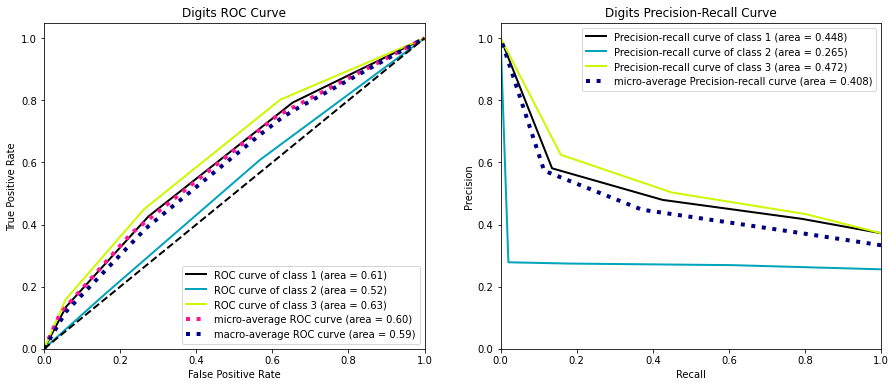

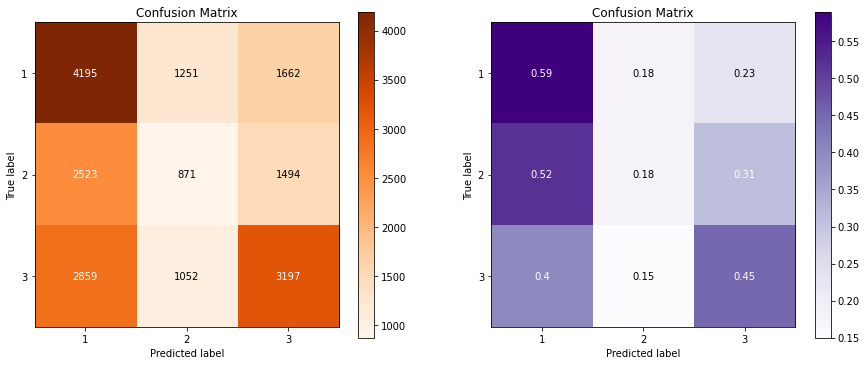

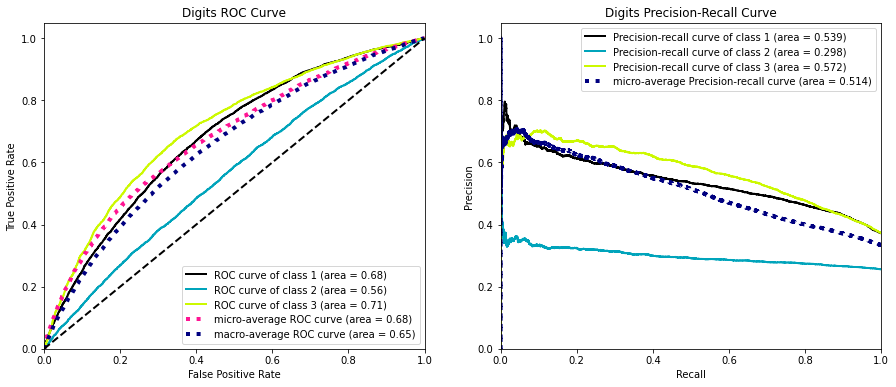

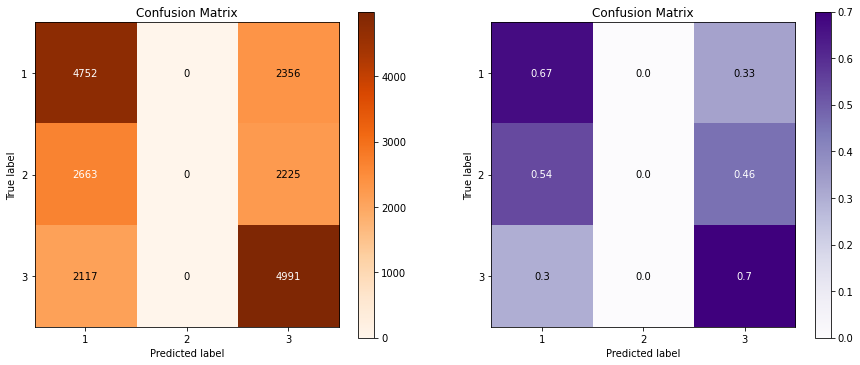

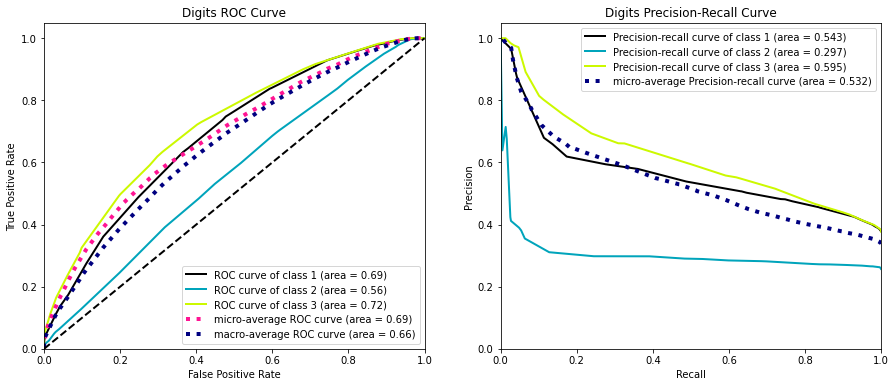

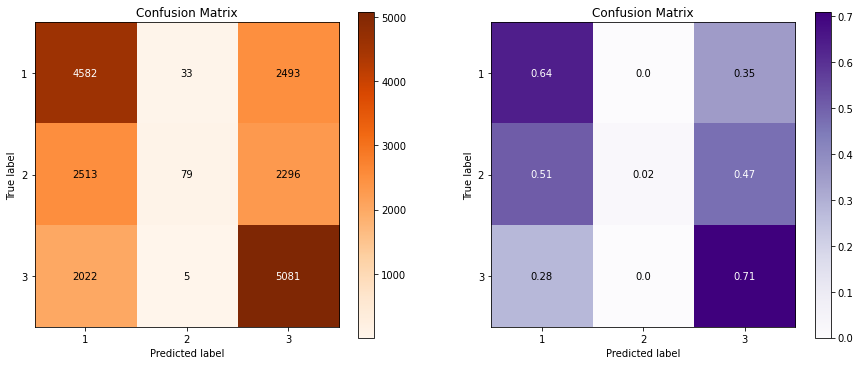

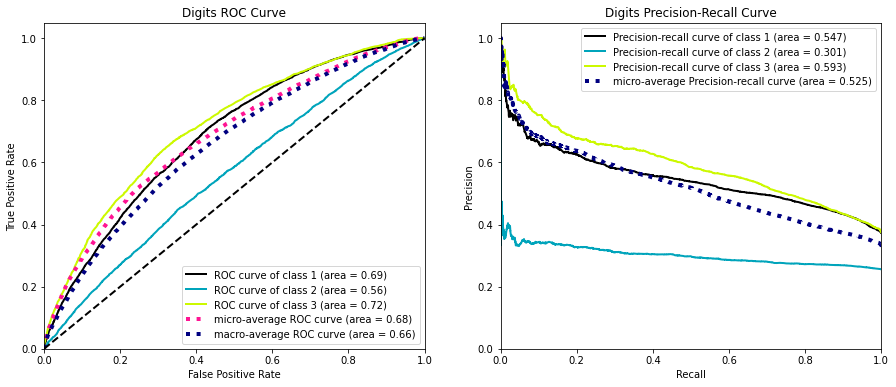

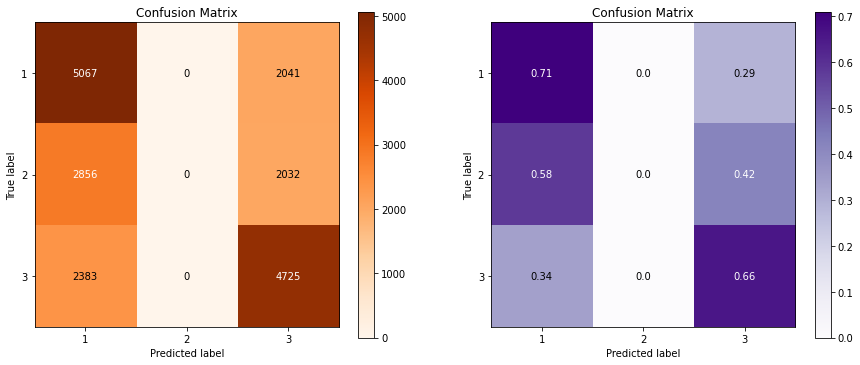

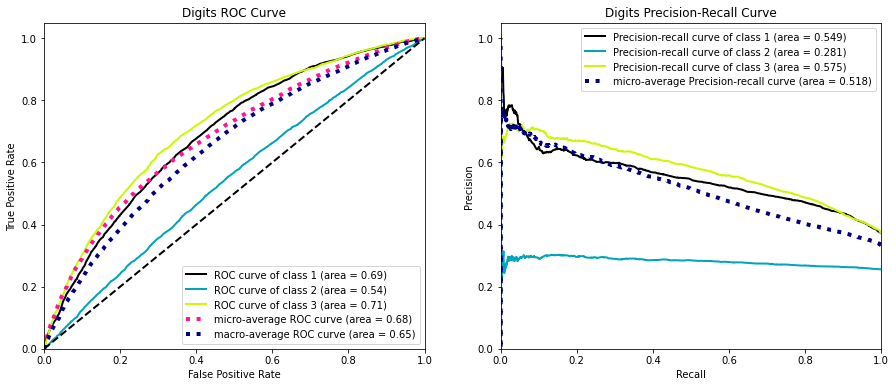

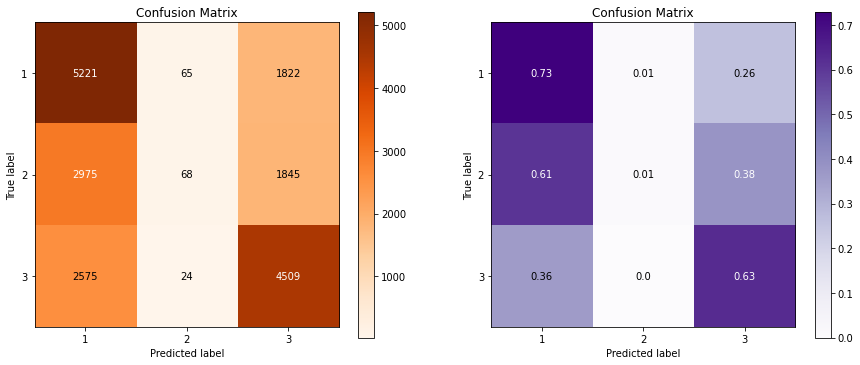

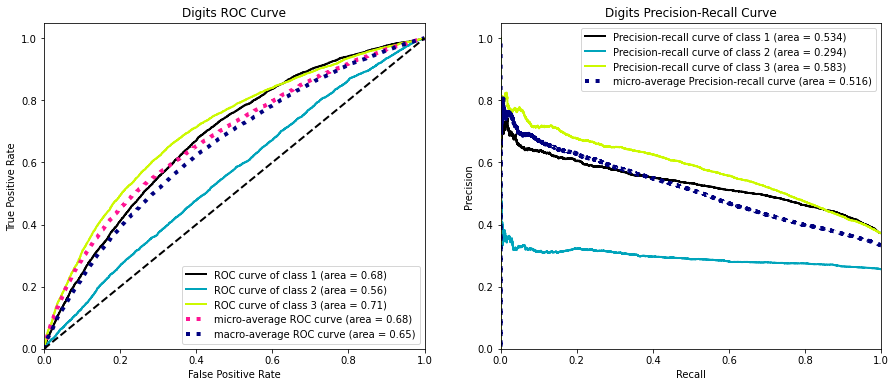

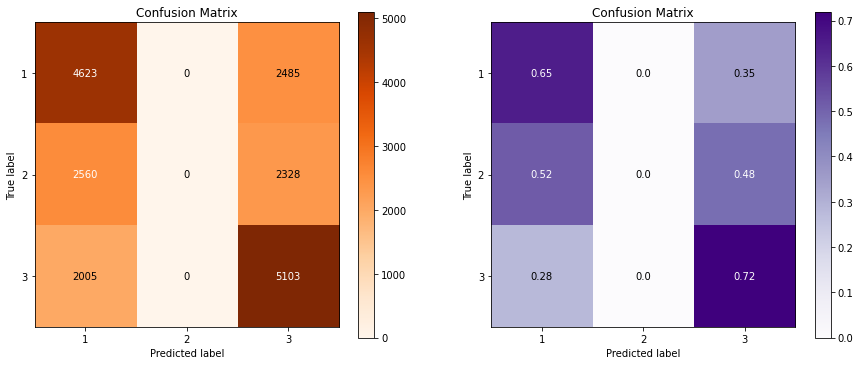

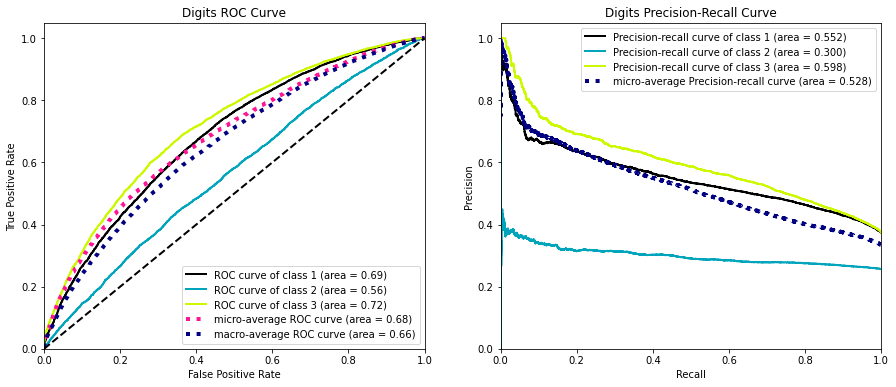

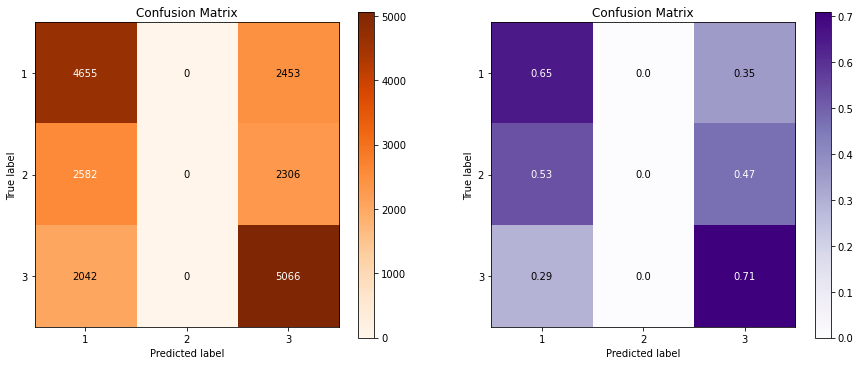

In [ ]:
names = ["Nearest Neighbors", "Logistic Regression",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "QDA"]
         
classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        prediction = clf.predict(X_test)
        accuracy_r2 = r2_score(y_test, prediction)
        print()
        print (name)
        print("-" * 20)
        print("acc: ",accuracy, "\tR2: ", accuracy_r2 )
        ROC_PRC_matrix(clf, y_test)
        confusion_matrix(clf, y_test)


Feature: 0, Score: 0.00010
Feature: 1, Score: -0.00004
Feature: 2, Score: -14.01015
Feature: 3, Score: 0.03207


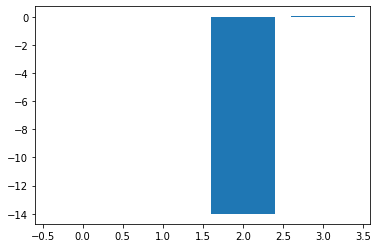

In [ ]:
# # get importance

# models = [lr_classifier]
  
# for model in models: 
# 	importance = model.coef_[0]
# 	#summarize feature importance
# 	for i,v in enumerate(importance):
# 		print('Feature: %0d, Score: %.5f' % (i,v))
# 	# plot feature importance
# 	pyplot.bar([x for x in range(len(importance))], importance)
# 	pyplot.show()